In [1]:
from __future__ import division, print_function
import nltk
from nltk import word_tokenize
import pandas as pd
from nltk.corpus import stopwords
import string
import sklearn
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import gensim 
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
from nltk.tokenize import sent_tokenize 
import numpy as np
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
import os
import collections
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns 
from sklearn.model_selection import KFold

Using TensorFlow backend.


In [2]:
df_pred = pd.read_csv('agr_en_fb_test.csv', header = None, delimiter = ',')
df_pred.columns = ['Sentence']
df = pd.read_csv('train.csv', 
                   header = None, 
                   delimiter=',')
df.columns = ['Text', 'Label']
df.head()

,Text,Label
0,Well said sonu..you have courage to stand agai...,OAG
1,"Most of Private Banks ATM's Like HDFC, ICICI e...",NAG
2,"Now question is, Pakistan will adhere to this?",OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,"??we r against cow slaughter,so of course it w...",NAG


### Class imbalance problem

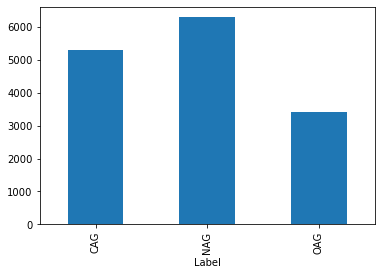

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [4]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

NAG    6284
CAG    5297
OAG    3419
Name: Label, dtype: int64

### Solving imbalance issue

In [5]:
from collections import Counter
def balanceClasses(xs, ys):
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)

    # the least common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[-1][1])

    num_added = {clss: 0 for clss in freqs.keys()}
    new_ys = []
    new_xs = []
    for i, ym in enumerate(ys):
        if num_added[ym] < max_allowable:
            new_ys.append(ym)
            new_xs.append(xs[i])
            num_added[ym] += 1
    return new_xs, new_ys

In [6]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])


In [7]:
data = pd.DataFrame(new_text)  
data.columns = ['Text']
data['Label'] = new_label

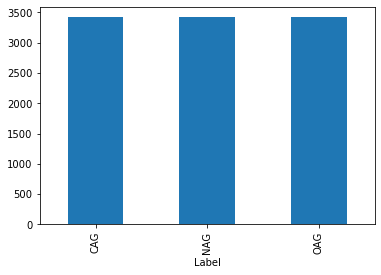

In [8]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [9]:
data.Label.value_counts()

OAG    3419
NAG    3419
CAG    3419
Name: Label, dtype: int64

### Data Preprocessing

In [10]:
# People usually join sentences using more than one colon 
def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [11]:
#Removing punctuations
data['Text'] = data['Text'].apply(lambda x:''.join([i for i in x if i not in string.punctuation]))

In [12]:
#Remove Emoji
def RemoveEmoji(inputString):
    return inputString.encode('ascii', 'ignore').decode('ascii')

data['Text'] = data['Text'].apply(lambda x: RemoveEmoji(x))

In [13]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [14]:
data.head(5)

,Text,Label
0,Well said sonu you have courage to stand again...,OAG
1,Most of Private Banks ATMs Like HDFC ICICI etc...,NAG
2,Now question is Pakistan will adhere to this,OAG
3,Pakistan is comprised of fake muslims who does...,OAG
4,we r against cow slaughterso of course it will...,NAG


In [15]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [16]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [17]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [18]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [19]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [20]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [21]:
OAG  = []
CAG = []
NAG = []
for l in data.Label:
    
    if l == 'OAG':
        OAG.append(1)
        CAG.append(0)
        NAG.append(0)
    elif l == 'CAG':
        OAG.append(0)
        CAG.append(1)
        NAG.append(0)
    elif l == 'NAG':
        OAG.append(0)
        CAG.append(0)
        NAG.append(1)
        
data['OAG']= OAG
data['CAG']= CAG
data['NAG']= NAG

data = data[['Text_Final', 'tokens', 'Label', 'OAG', 'CAG', 'NAG']]

In [22]:
category_id = []
for l in data.Label:
    
    if l == 'OAG':
        category_id.append('0')
    elif l == 'CAG':
        category_id.append('1')
    elif l == 'NAG':
           category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', 'OAG', 'CAG', 'NAG', 'Category_id' ]]
data.head()

,Text_Final,tokens,Label,OAG,CAG,NAG,Category_id
0,well said sonu courage stand dadagiri muslim,"[well, said, sonu, courage, stand, dadagiri, m...",OAG,1,0,0,0
1,private bank atm like hdfc icici etc cash publ...,"[private, bank, atm, like, hdfc, icici, etc, c...",NAG,0,0,1,2
2,question pakistan adhere,"[question, pakistan, adhere]",OAG,1,0,0,0
3,pakistan comprised fake muslim doe know meanin...,"[pakistan, comprised, fake, muslim, doe, know,...",OAG,1,0,0,0
4,r cow slaughterso course stop leather manufact...,"[r, cow, slaughterso, course, stop, leather, m...",NAG,0,0,1,2


In [23]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 20 % for testing. We use random state so every time we get the same training and testing data.

In [24]:
data_train, data_test = train_test_split(data, test_size=0.20, random_state=42)


In [25]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google News Word2Vec model

In [26]:
word2vec_path = 'GoogleNews-vectors-negative300.bin'
#word2vec_path = 'glove.6B.50d.word2vec'

In [27]:
from gensim import models
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [28]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

### Tokenize and Pad sequences

In [29]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [30]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 17207 unique tokens.


In [31]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [32]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(17208, 300)


In [33]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement

In [34]:
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
   
    model.summary()
    return model

In [35]:
label_names = ['OAG', 'CAG', 'NAG']

In [36]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [37]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [38]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      5162400     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 512)      307712      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 48, 512)      461312      embedding_1[0][0]                
____________________________________________________________________________________________

### Train CNN

In [39]:
num_epochs = 12
batch_size = 512

In [40]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 7384 samples, validate on 821 samples
Epoch 1/12
7384/7384 [==============================] - 14s 2ms/step - loss: 1.5530 - accuracy: 0.3363 - val_loss: 1.0882 - val_accuracy: 0.3520
Epoch 2/12
7384/7384 [==============================] - 14s 2ms/step - loss: 1.0800 - accuracy: 0.4185 - val_loss: 1.0749 - val_accuracy: 0.3581
Epoch 3/12
7384/7384 [==============================] - 14s 2ms/step - loss: 1.0391 - accuracy: 0.4760 - val_loss: 1.0333 - val_accuracy: 0.4775
Epoch 4/12
7384/7384 [==============================] - 14s 2ms/step - loss: 0.9724 - accuracy: 0.5402 - val_loss: 0.9807 - val_accuracy: 0.5213
Epoch 5/12
7384/7384 [==============================] - 14s 2ms/step - loss: 0.8916 - accuracy: 0.5952 - val_loss: 0.9452 - val_accuracy: 0.5396
Epoch 6/12
7384/7384 [==============================] - 14s 2ms/step - loss: 0.8091 - accuracy: 0.6502 - val_loss: 0.9354 - val_accuracy: 0.5359
Epoch 7/12
7384/7384 [==============================] - 14s 2ms/step - loss: 0.7143

In [41]:
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

2052/2052 [==============================] - 1s 586us/step


In [42]:
labels = ['OAG', 'CAG', 'NAG']

In [43]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [44]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.5423976608187134

In [45]:
data_test.Label.value_counts()

OAG    690
CAG    686
NAG    676
Name: Label, dtype: int64

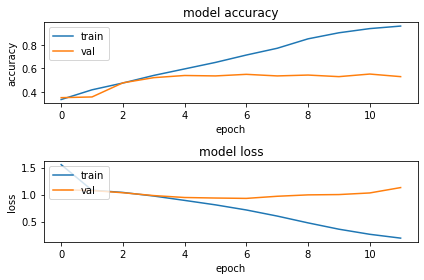

In [46]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [47]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[191 202 293]
 [112 433 131]
 [124  77 489]]
Accuracy Score : 0.5423976608187134
Report : 
              precision    recall  f1-score   support

         CAG       0.45      0.28      0.34       686
         NAG       0.61      0.64      0.62       676
         OAG       0.54      0.71      0.61       690

    accuracy                           0.54      2052
   macro avg       0.53      0.54      0.53      2052
weighted avg       0.53      0.54      0.53      2052



                        Convolution Neural Network


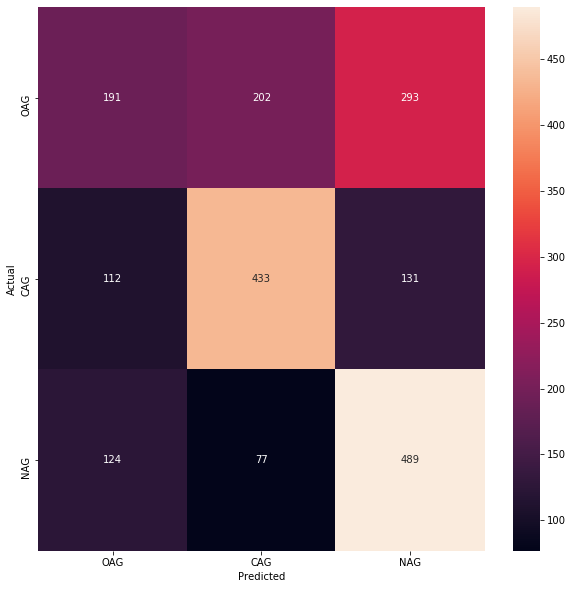

In [48]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.Label, prediction_labels)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Testing CNN using KFold cross validation

In [49]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import zscore
from sklearn import metrics

f_score=[]
fold = 10
label_names = ['OAG', 'CAG', 'NAG']
num_epochs = 12
batch_size = 512
oos_y = []
oos_pred = []
#for train, test in kf.split(data["tokens"], data['Label']):
for i in range(fold):
    data_train, data_test = train_test_split(data, test_size=0.20, random_state = np.random.randint(1,100, 1)[0])

    # # total training words
    totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

    # # Storing Length of the training sentence
    lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

    # # training Vocabulary size
    trainingVocabSize = sorted(list(set(totalTrainingWords)))

    ## Total number of lines
    linesCount = len(data_train["tokens"])
    
    tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
    tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
    training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

    train_word_index = tokenizer.word_index
    cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
    
    for word,index in train_word_index.items():
        train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
        
    test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
    cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)
    
    # Splitting train data into X_train and y_train
    y_train = data_train[label_names].values
    x_train = cnnTrainData
    y_tr = y_train
    
    # Splitting train data into X_test and y_test
    y_test = data_test[label_names].values
    x_test = cnnTestData
    y_tst = y_test
    
    model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))
    history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size, verbose = 0)
    predictions = model.predict(cnnTestData, batch_size=1024, verbose=0)
    oos_y.append(y_test)
    oos_pred.append(predictions)
    score = np.sqrt(metrics.mean_squared_error(predictions, y_test))
    f_score.append(score) 

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      5162400     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 49, 512)      307712      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 48, 512)      461312      embedding_2[0][0]                
____________________________________________________________________________________________

In [50]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [51]:

score = np.sqrt(metrics.mean_squared_error(oos_pred, oos_y))
for i in range(fold):
    print((i+1), "Fold Score: ", f_score[i])

print(f" Average Accuracy : {score}" )

1 Fold Score:  0.4507026096996025
2 Fold Score:  0.4506577488027768
3 Fold Score:  0.4542720738653939
4 Fold Score:  0.45486839718847777
5 Fold Score:  0.44333372030560875
6 Fold Score:  0.4412343775558587
7 Fold Score:  0.4510633458561434
8 Fold Score:  0.4429380161447669
9 Fold Score:  0.4473166171136163
10 Fold Score:  0.45317983051644917
 Average Accuracy : 0.44898135052049154


# Support Vector Method (SVM) and Random Forest Method (RFM)

### Generating features using TF-IDF Vectorizer method

In [52]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.Label
features.shape

(10257, 22312)

Now, each of 10257 comment (text row) is represented by 22312 features
representing the tf-idf score for different unigrams, bigrams and trigrams.

### Testing SVM and RFM models using K-fold cross validation


In [53]:

# Creating two model and storing their accuracies
models = [LinearSVC(), RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)]

# KFold cross-validation
kFold = 10
entries = []
for model in models:
    model_name = model.__class__.__name__
    
    #To get accuracy of the model for 10 different splits
    scoreValue = cross_val_score(model, features, labels, scoring='accuracy', cv= kFold)
    
    # append name and score of each model with different splits
    for fold_idx, accuracy in enumerate(scoreValue):
        entries.append((model_name, fold_idx, accuracy))


In [54]:
#generating  a dataframe to store model and their different accuracies
model_df = pd.DataFrame(index=range(kFold * len(models)))

# Storing in Dataframe with column name
model_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [55]:
# average of all the K-fold accuracies
model_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.543048
RandomForestClassifier    0.499662
Name: accuracy, dtype: float64

In [56]:
### Spliting data having similar split as CNN

In [57]:
# Using similar split as CNN model
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.20, random_state=42)

### SVM - Generating model 

In [58]:
# generate Linear SVM model
model = LinearSVC()
clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### SVM - Showing some prediction

In [59]:
print(clf.predict(vectorizer.transform(["Modi ho ya Manmohan singh saala yeh log kuch ny karta hai sirf vote ka lia 56 ka seena dikahata hai"])))

['OAG']


In [60]:
print(clf.predict(vectorizer.transform(["i am micro investor, need advise on adding stocks on monthly basis !"])))

['NAG']


In [61]:
print(clf.predict(vectorizer.transform(["These media fellows have time to dissect one's social media profile,but none of spineless jokers has the guts to question as to why and how a convict like Lalu Yadav is roaming outside and running a Government."])))

['CAG']


###  SVM - Displaying false-positive rate (FPR) and true positive rate (TPR)

                          Support Vector Method


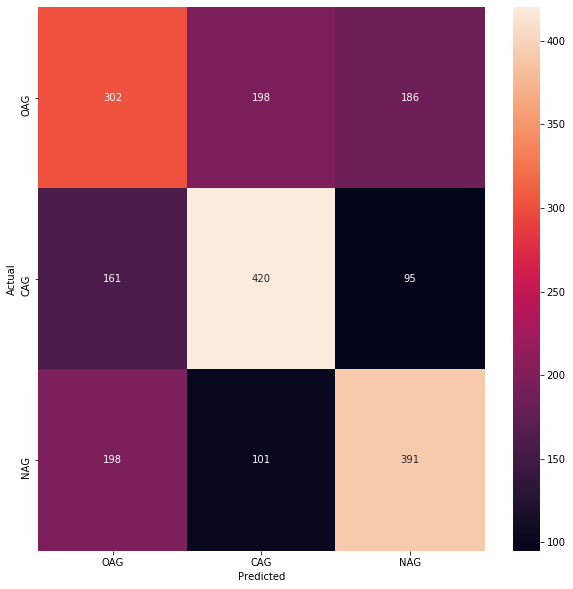

In [62]:
from sklearn.metrics import confusion_matrix
print("                          Support Vector Method")
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### SVM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix

In [63]:
results = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[302 198 186]
 [161 420  95]
 [198 101 391]]
Accuracy Score : 0.5423976608187134
Report : 
              precision    recall  f1-score   support

         CAG       0.46      0.44      0.45       686
         NAG       0.58      0.62      0.60       676
         OAG       0.58      0.57      0.57       690

    accuracy                           0.54      2052
   macro avg       0.54      0.54      0.54      2052
weighted avg       0.54      0.54      0.54      2052



# RFM - Generate model

In [64]:
model1 = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
clf1 = model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)

### RFM - Showing some prediction

In [65]:
print(clf1.predict(vectorizer.transform(["Modi ho ya Manmohan singh saala yeh log kuch ny karta hai sirf vote ka lia 56 ka seena dikahata hai"])))

['CAG']


In [66]:
print(clf1.predict(vectorizer.transform(["i am micro investor, need advise on adding stocks on monthly basis !"])))

['NAG']


In [67]:
print(clf1.predict(vectorizer.transform(["These media fellows have time to dissect one's social media profile,but none of spineless jokers has the guts to question as to why and how a convict like Lalu Yadav is roaming outside and running a Government."])))

['NAG']


### RFM - Displaying false-positive rate (FPR) and true positive rate (TPR)

                           Random Forest Method


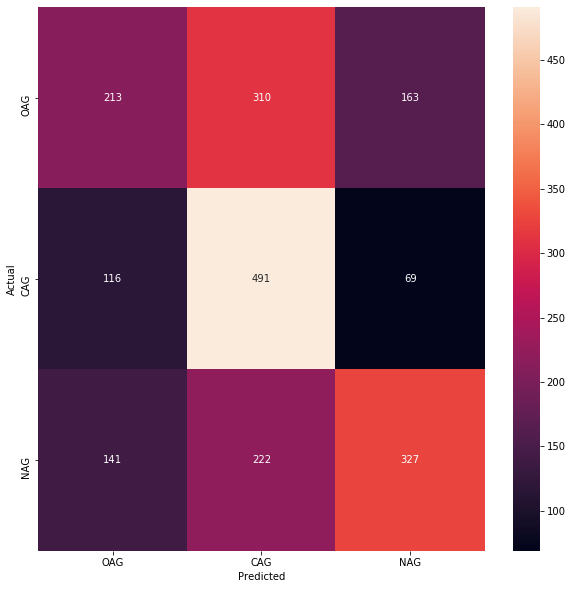

In [68]:
from sklearn.metrics import confusion_matrix
print("                           Random Forest Method")
conf_mat = confusion_matrix(y_test, y_pred1)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### RFM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [69]:
results1 = confusion_matrix(y_test, y_pred1)
print ('Confusion Matrix :')
print(results1) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred1))
print ('Report : ')
print (classification_report(y_test, y_pred1))

Confusion Matrix :
[[213 310 163]
 [116 491  69]
 [141 222 327]]
Accuracy Score : 0.5024366471734892
Report : 
              precision    recall  f1-score   support

         CAG       0.45      0.31      0.37       686
         NAG       0.48      0.73      0.58       676
         OAG       0.58      0.47      0.52       690

    accuracy                           0.50      2052
   macro avg       0.51      0.50      0.49      2052
weighted avg       0.51      0.50      0.49      2052

